# Customer Base Analytics

In [392]:
import pandas as pd
import datetime
from tqdm.auto import tqdm
import json
import torch
from torch.utils.data import TensorDataset, DataLoader
import pytorch_model.abstract_lstm as abstract_lstm
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt
import helpers.post_processing as postprocessing
import helpers.pre_processing as preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import importlib
import pyreadr
import lifetimes
importlib.reload(preprocessing)
importlib.reload(postprocessing)
importlib.reload(abstract_lstm)

<module 'pytorch_model.abstract_lstm' from '/Users/tom.wuesten/privat_code/CLV/src/CLV/pytorch_model/abstract_lstm.py'>

## CDNOW Data

In [214]:
cols=["customer_id", "date", "amount", "revenue in $"]
df_cdnow = pd.read_fwf("data/CDNOW_master.txt", header=None, names= cols)
df_cdnow["date"] = pd.to_datetime(df_cdnow["date"],format='%Y%m%d')
#df_cdnow["week"] = df_cdnow["date"].dt.isocalendar().week-1
#df_cdnow["year"] = df_cdnow["date"].dt.isocalendar().year
df_cdnow.head()

,customer_id,date,amount,revenue in $
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [215]:
# define the training (calibration) and prediction (holdout) period

training_start_cdnow = '1997-01-01'
training_end_cdnow   = '1997-09-23'
holdout_start_cdnow  = '1997-09-23'
holdout_end_cdnow    = '1998-06-30'
date_format    = '%Y-%m-%d'

In [216]:
# display basic stats

cohort_accounts = df_cdnow.groupby('customer_id').min().query(
    'date <= @training_end_cdnow').reset_index()['customer_id'].tolist()

df_cdnow = df_cdnow.query('customer_id in @cohort_accounts')
df_cdnow = df_cdnow.sort_values(by='customer_id').reset_index(drop=True)

print(f"Accounts in dataset:  {len(df_cdnow['customer_id'].unique())}")
print(f"Total transactions: {len(df_cdnow)}")

Accounts in dataset:  23570
Total transactions: 69659


In [288]:
# count aggregate stats

aggregate_counts = df_cdnow.copy(deep=True)
aggregate_counts['year'] = aggregate_counts['date'].dt.year
aggregate_counts['week'] = (aggregate_counts['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
aggregate_counts = aggregate_counts.groupby(['year', 'week']).agg({'customer_id': 'count', 'date': 'min'}).reset_index()
aggregate_counts.shape

(78, 4)

In [227]:



# group by customerID, week, and year columns and replace date with the maximum date value within each group
aggregate_counts['date'] = aggregate_counts.groupby(['customer_id', 'week', 'year'])['date'].transform(min)

# print resulting dataframe
aggregate_counts


,customer_id,date,amount,revenue in $,year,week
0,1,1997-01-01,1,11.77,1997,0
1,2,1997-01-12,1,12.00,1997,1
2,2,1997-01-12,5,77.00,1997,1
3,3,1997-11-25,4,20.96,1997,47
4,3,1997-11-15,5,57.45,1997,45
...,...,...,...,...,...,...
69654,23568,1997-04-22,1,14.99,1997,16
69655,23568,1997-03-25,1,22.97,1997,12
69656,23569,1997-03-25,2,25.74,1997,12
69657,23570,1997-03-25,3,51.12,1997,12


In [221]:
aggregate_counts.sort_values(by=["week"])

,customer_id,date,amount,revenue in $,year,week
0,1,1997-01-01,1,11.77,1997,0
32362,10516,1998-01-01,4,74.46,1998,0
2353,702,1997-01-03,2,41.13,1997,0
2355,703,1997-01-04,8,121.34,1997,0
2356,704,1997-01-03,2,28.13,1997,0
...,...,...,...,...,...,...
66619,22506,1997-12-23,1,14.99,1997,51
46149,15162,1997-12-23,1,11.99,1997,51
66620,22506,1997-12-23,1,14.99,1997,51
27147,8670,1997-12-29,1,14.49,1997,51


In [ ]:
aggregate_counts.head()

In [ ]:
aggregate_counts[aggregate_counts.index == 77]
'1997-09-23'

In [ ]:
len(aggregate_counts[aggregate_counts.date < training_end_cdnow])

In [ ]:
# display aggregate calibration and holdout transactions plot

plt.figure(figsize=(16,5))
plt.plot(aggregate_counts[aggregate_counts.date <= training_end_cdnow].index, 
         aggregate_counts[aggregate_counts.date <= training_end_cdnow]['customer_id'], color='black', label='calibration')
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow].index, 
         aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]['customer_id'], color='blue', label='holdout')
plt.axvline(len(aggregate_counts[aggregate_counts.date <= training_end_cdnow])-1, linestyle=':')
plt.xticks(aggregate_counts.index[::2])
plt.title('Weekly Aggregate Transactions - Calibration and Holdout')
plt.legend()
plt.savefig("plots_valendin/calibration_holdout.png", dpi=600)
plt.show()

# note the prominent monthly pattern with spiky first weeks

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Create a figure with a custom grid
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

# First subplot: calibration and holdout plot
ax1 = plt.subplot(gs[0])
ax1.plot(aggregate_counts[aggregate_counts.date <= training_end_cdnow].index, 
         aggregate_counts[aggregate_counts.date <= training_end_cdnow]['customer_id'], color='black', label='calibration')
ax1.plot(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow].index, 
         aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]['customer_id'], color='blue', label='holdout')
ax1.axvline(len(aggregate_counts[aggregate_counts.date <= training_end_cdnow])-1, linestyle=':')
ax1.set_xticks(aggregate_counts.index[::2])
ax1.set_title('Weekly Aggregate Transactions - Calibration and Holdout')
ax1.legend()

# Second subplot: cumulative transaction plot for holdout data only
ax2 = plt.subplot(gs[1])
holdout_counts = aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]
cumulative_transaction = np.cumsum(holdout_counts['customer_id'])
ax2.plot(holdout_counts.index, cumulative_transaction, color='blue', label='holdout')
ax2.set_xticks(holdout_counts.index[::5])
ax2.set_title('Cumulative Transactions - Holdout')
ax2.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Save and show the figure
plt.savefig("plots_valendin/holdout_cumulative.png", dpi=600)
plt.show()


In [385]:
pre_process_cdnow = preprocessing.Preprocessing(df=df_cdnow,
training_start=training_start_cdnow,
training_end=training_end_cdnow,
holdout_start=holdout_start_cdnow,
holdout_end=holdout_end_cdnow,
batch_train_size=32,
name="cdnow")

In [386]:
train_dataloader, valid_dataloader = pre_process_cdnow.run(dl_framwork="pytorch")

TRUE


preparing dataset:   0%|          | 0/23570 [00:00<?, ?it/s]

Shape of x_train: torch.Size([21213, 37, 2]) Shape of x_val: torch.Size([2357, 37, 2])


In [387]:
pre_process_cdnow.seq_len

37

In [393]:
with open("feature_config.json", "r") as f:
    data = json.load(f)
max_weeks = data["cdnow"]["features"]["weeks"]
max_trans = data["cdnow"]["features"]["trans"]
model3 = abstract_lstm.Abstract_Lstm(max_weeks=max_weeks,max_trans=max_trans)
model3.train(num_epochs=10,learning_rate=0.01,training_loader=train_dataloader,validation_loader=valid_dataloader)

193989510976262.9
136933772453832.66
125522624749346.6
110307761143365.22
95092897537383.8
91289181635888.45
72270602128411.7
Best Epoch: 8, mape: 72270602128411.70312


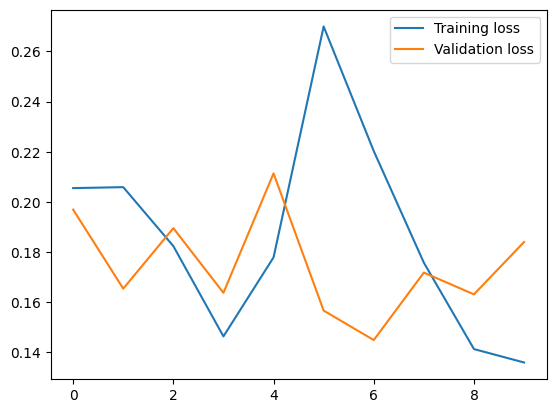

In [394]:
model3.plot_losses()

In [395]:
model3.get_model_summary()

LSTMModel(
  (embdedding_week): Embedding(52, 8)
  (embedding_transaction): Embedding(25, 6)
  (lstm): LSTM(14, 128, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=25, bias=True)
  (softmax_layer): Softmax(dim=2)
)

In [396]:

post_process_cdnow = postprocessing.Postprocessing(
        df= df_cdnow,
        model= model3,
        holdout_calender = pre_process_cdnow.calender,
        calibration= pre_process_cdnow.calibration,
        calender = pre_process_cdnow.calender,
        batch_size_pred = pre_process_cdnow.no_valid_samples,
        holdout = pre_process_cdnow.holdout,
        training_end = training_end_cdnow,
        holdout_start = holdout_end_cdnow,
        name="cdnow"
)

In [397]:
post_process_cdnow.run(dl_framework="pytorch")

The seed shape is individuals (23570) X calibration length (38) X number of features (2)
no_samples=23570
no_timesteps=38
no_features=2
no_batches=10


simulating scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

predictions.shape=(2, 23570, 77, 1)


In [ ]:
post_process_cdnow.convertet_predictions.shape

In [ ]:
test = np.mean(post_process_cdnow.convertet_predictions, axis=0)

In [ ]:
test = np.squeeze(test)

In [ ]:
test[:,38:].shape

In [ ]:
post_process_cdnow.holdout

## CDNOW Pareto NBD

In [179]:
cols=["customer_id", "date", "amount", "revenue in $"]
df_cdnow = pd.read_fwf("data/CDNOW_master.txt", header=None, names= cols)
df_cdnow["date"] = pd.to_datetime(df_cdnow["date"],format='%Y%m%d')
#df_cdnow["week"] = df_cdnow["date"].dt.isocalendar().week-1
#df_cdnow["year"] = df_cdnow["date"].dt.isocalendar().year
df_cdnow.head()

,customer_id,date,amount,revenue in $
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [180]:
# define the training (calibration) and prediction (holdout) period

training_start_cdnow = '1997-01-01'
training_end_cdnow   = '1997-09-23'
holdout_start_cdnow  = '1997-09-23'
holdout_end_cdnow    = '1998-06-30'
date_format    = '%Y-%m-%d'

In [181]:
# display basic stats

cohort_accounts = df_cdnow.groupby('customer_id').min().query(
    'date <= @training_end_cdnow').reset_index()['customer_id'].tolist()

df_cdnow = df_cdnow.query('customer_id in @cohort_accounts')
df_cdnow = df_cdnow.sort_values(by='customer_id').reset_index(drop=True)

print(f"Accounts in dataset:  {len(df_cdnow['customer_id'].unique())}")
print(f"Total transactions: {len(df_cdnow)}")

Accounts in dataset:  23570
Total transactions: 69659


In [182]:
# count aggregate stats

aggregate_counts = df_cdnow.copy(deep=True)
aggregate_counts['year'] = aggregate_counts['date'].dt.year
aggregate_counts['week'] = (aggregate_counts['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
aggregate_counts = aggregate_counts.groupby(['year', 'week']).agg({'customer_id': 'count', 'date': 'min'}).reset_index()
aggregate_counts.shape

(78, 4)

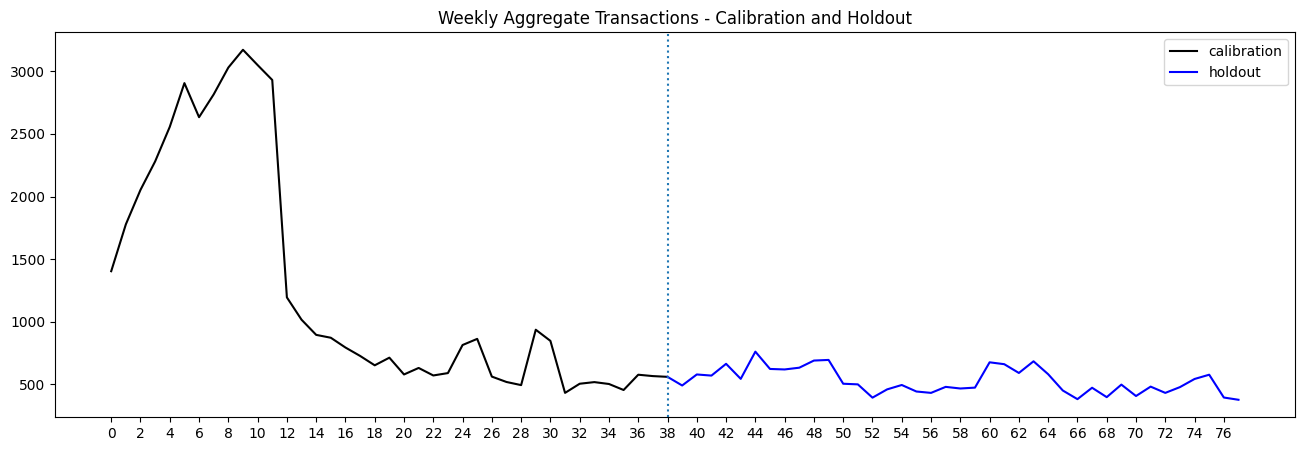

In [183]:
# display aggregate calibration and holdout transactions plot

plt.figure(figsize=(16,5))
plt.plot(aggregate_counts[aggregate_counts.date <= training_end_cdnow].index, 
         aggregate_counts[aggregate_counts.date <= training_end_cdnow]['customer_id'], color='black', label='calibration')
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow].index, 
         aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]['customer_id'], color='blue', label='holdout')
plt.axvline(len(aggregate_counts[aggregate_counts.date <= training_end_cdnow])-1, linestyle=':')
plt.xticks(aggregate_counts.index[::2])
plt.title('Weekly Aggregate Transactions - Calibration and Holdout')
plt.legend()
plt.savefig("plots_valendin/calibration_holdout.png", dpi=600)
plt.show()

# note the prominent monthly pattern with spiky first weeks

In [235]:
calibration_df = df_cdnow[df_cdnow.date <= training_end_cdnow]
test_df = df_cdnow[df_cdnow.date >= holdout_start_cdnow]

In [238]:
test_df['year'] = test_df['date'].dt.year
test_df['week'] = (test_df['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
test_df['date'] = test_df.groupby(['customer_id', 'week', 'year'])['date'].transform(min)

In [242]:
print(test_df["customer_id"].nunique())
calibration_df["customer_id"].nunique()

7167


23570

In [230]:
calibration_df['year'] = calibration_df['date'].dt.year
calibration_df['week'] = (calibration_df['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
calibration_df['date'] = calibration_df.groupby(['customer_id', 'week', 'year'])['date'].transform(min)

In [231]:
calibration_df.head()

,customer_id,date,amount,revenue in $,year,week
0,1,1997-01-01,1,11.77,1997,0
1,2,1997-01-12,1,12.00,1997,1
2,2,1997-01-12,5,77.00,1997,1
6,3,1997-03-30,2,20.76,1997,12
7,3,1997-01-02,2,20.76,1997,0


In [300]:
pareto_nbd = lifetimes.ParetoNBDFitter()
summary = lifetimes.utils.summary_data_from_transaction_data(calibration_df,"customer_id", "date")
print(summary)

             frequency  recency      T
customer_id                           
1                  0.0      0.0  265.0
2                  0.0      0.0  254.0
3                  2.0     90.0  264.0
4                  2.0    213.0  265.0
5                  7.0    257.0  265.0
...                ...      ...    ...
23566              0.0      0.0  182.0
23567              0.0      0.0  182.0
23568              2.0     28.0  182.0
23569              0.0      0.0  182.0
23570              1.0      1.0  182.0

[23570 rows x 3 columns]


In [243]:
from datetime import date
holdout_start_cdnow  = '1997-09-23'
holdout_end_cdnow    = '1998-06-30'
d0 = date(1997, 9, 23)
d1 = date(1998, 6, 30)
delta = d1 - d0
print('The number of days between the given range of dates is :')
print(delta.days)

The number of days between the given range of dates is :
280


In [301]:
pareto_nbd.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.ParetoNBDFitter: fitted with 23570 subjects, alpha: 80.22, beta: 63.60, r: 0.59, s: 0.54>

In [252]:
t = 100 #predict purchases in 10 periods
individual = summary.iloc[2]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
pareto_nbd.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.2770876399588614

In [261]:
summary.head

<bound method NDFrame.head of              frequency  recency      T
customer_id                           
1                  0.0      0.0  265.0
2                  0.0      0.0  254.0
3                  2.0     90.0  264.0
4                  2.0    213.0  265.0
5                  7.0    257.0  265.0
...                ...      ...    ...
23566              0.0      0.0  182.0
23567              0.0      0.0  182.0
23568              2.0     28.0  182.0
23569              0.0      0.0  182.0
23570              1.0      1.0  182.0

[23570 rows x 3 columns]>

In [304]:
agg_trans = 0
for element in summary.index-1:
    individual = summary.iloc[element]
    prob = pareto_nbd.predict(7, individual['frequency'], individual['recency'], individual['T'])
    agg_trans += round(prob, 0)

In [302]:
for element in summary.index-1:
    individual = summary.iloc[element]
    prob = pareto_nbd.predict(7, individual['frequency'], individual['recency'], individual['T'])
    agg_trans += round(prob, 0)

In [305]:
agg_trans

21.0

In [306]:
start_date = datetime.date(1997, 9, 23)
week_list = list()
for i in range(41):
    current_date = start_date + datetime.timedelta(days=i*7)

    if current_date <= start_date + datetime.timedelta(days=280):
        if i > 0:
            agg_trans = 0
            for element in summary.index-1:
                individual = summary.iloc[element]
                prob = pareto_nbd.predict(i*7, individual['frequency'], individual['recency'], individual['T'])
                agg_trans += round(prob, 0)
            week_list.append(agg_trans)
    else:
        break

In [318]:
diff_list = []
for i in range(0, len(week_list)):
    if i!= 0:
        diff = week_list[i] - week_list[i-1]
        diff_list.append(diff)
    else:
        diff_list.append(week_list[i])


In [319]:
len(diff_list)

40

In [287]:
aggregate_counts[aggregate_counts.date >= holdout_start_cdnow].index

Int64Index([    3,     4,     5,    12,    14,    15,    16,    26,    27,
               28,
            ...
            69622, 69624, 69629, 69630, 69631, 69636, 69642, 69643, 69646,
            69649],
           dtype='int64', length=21205)

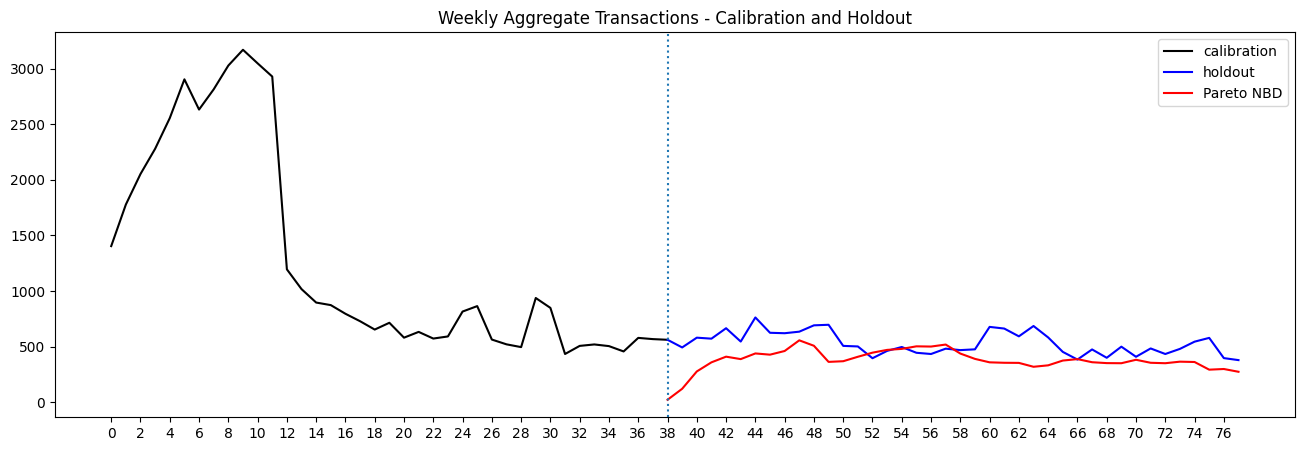

In [320]:
plt.figure(figsize=(16,5))
plt.plot(aggregate_counts[aggregate_counts.date <= training_end_cdnow].index, 
         aggregate_counts[aggregate_counts.date <= training_end_cdnow]['customer_id'], color='black', label='calibration')
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow].index, 
         aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]['customer_id'], color='blue', label='holdout')
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow].index, diff_list, color='red', label='Pareto NBD')
plt.axvline(len(aggregate_counts[aggregate_counts.date <= training_end_cdnow])-1, linestyle=':')
plt.xticks(aggregate_counts.index[::2])
plt.title('Weekly Aggregate Transactions - Calibration and Holdout')
plt.legend()
plt.savefig("plots_valendin/calibration_holdout.png", dpi=600)
plt.show()

In [321]:
from statsmodels.tsa.arima.model import ARIMA

In [322]:
arima_data = aggregate_counts[aggregate_counts.date <= training_end_cdnow]
test_df = aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]

In [323]:
arima_data.head()

,year,week,customer_id,date
0,1997,0,1404,1997-01-01
1,1997,1,1778,1997-01-07
2,1997,2,2053,1997-01-14
3,1997,3,2280,1997-01-21
4,1997,4,2556,1997-01-28


In [324]:
type(arima_data["customer_id"])

pandas.core.series.Series

In [376]:
# fit model
model = ARIMA(arima_data["customer_id"], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            customer_id   No. Observations:                   39
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -274.363
Date:                Thu, 23 Mar 2023   AIC                            554.726
Time:                        08:46:23   BIC                            559.638
Sample:                             0   HQIC                           556.473
                                 - 39                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4378      1.883      0.233      0.816      -3.252       4.128
ma.L1         -0.2611      2.053     -0.127      0.899      -4.285       3.762
sigma2      1.097e+05   1.09e+04     10.073      0.0

In [377]:
holdout_start_cdnow  = '1997-09-23'
holdout_end_cdnow    = '1998-06-30'

In [378]:
output = model_fit.forecast(steps=len(test_df))

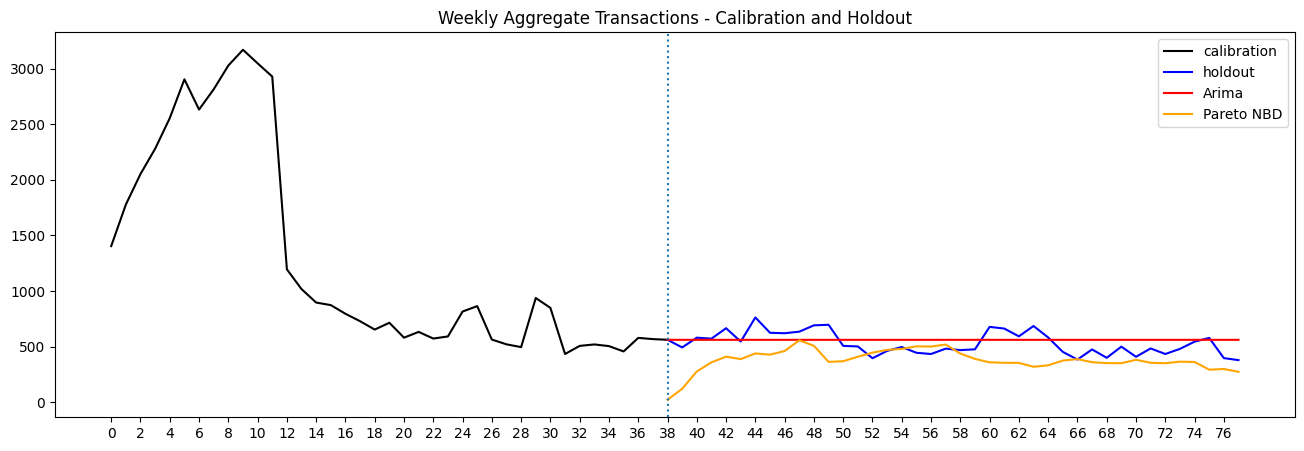

In [379]:
plt.figure(figsize=(16,5))
plt.plot(aggregate_counts[aggregate_counts.date <= training_end_cdnow].index, 
         aggregate_counts[aggregate_counts.date <= training_end_cdnow]['customer_id'], color='black', label='calibration')
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow].index, 
         aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]['customer_id'], color='blue', label='holdout')
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow].index, output, color='red', label='Arima')
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow].index, diff_list, color='orange', label='Pareto NBD')
plt.axvline(len(aggregate_counts[aggregate_counts.date <= training_end_cdnow])-1, linestyle=':')
plt.xticks(aggregate_counts.index[::2])
plt.title('Weekly Aggregate Transactions - Calibration and Holdout')
plt.legend()
plt.savefig("plots_valendin/calibration_holdout.png", dpi=600)
plt.show()

## Statistics Arima

In [380]:
MAPE = mean_absolute_percentage_error(np.array(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]['customer_id']), np.array(output)) * 100
print(f'MAPE = {MAPE}')

MAPE = 18.50030360052177


In [381]:
RMSE = np.sqrt(mean_squared_error(np.array(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]['customer_id']), output))
print(f'RMSE = {RMSE}')

RMSE = 104.87431774137974


In [382]:
actual_holdout = sum(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]['customer_id'])
y_pred = sum(output)
bias = (100 *(y_pred-actual_holdout)/actual_holdout)
print(f'Prediction Bias = {bias}')

Prediction Bias = 5.7383805287834475


## Statistics NBD/Pareto

In [348]:
MAPE = mean_absolute_percentage_error(np.array(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]['customer_id']), np.array(diff_list)) * 100
print(f'MAPE = {MAPE}')

MAPE = 29.200990730483074


In [349]:
RMSE = np.sqrt(mean_squared_error(np.array(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]['customer_id']), diff_list))
print(f'RMSE = {RMSE}')

RMSE = 205.90993176629436


In [351]:
actual_holdout = sum(aggregate_counts[aggregate_counts.date >= holdout_start_cdnow]['customer_id'])
y_pred = sum(diff_list)
bias = (100 *(y_pred-actual_holdout)/actual_holdout)
print(f'Prediction Bias = {bias}')

Prediction Bias = -29.04975241688281


## Moia Data

In [130]:
moia_df = pd.read_csv("data/moia_data.csv")
moia_df = moia_df.drop(columns=["Unnamed: 0"])
moia_df.head()

,date,customer_id,special_trips,amount_trips
0,2022-08-23,5238510068743616989,5,109.0
1,2022-08-23,-3004308863050107066,25,90.0
2,2022-05-24,2991444851614457026,1,66.0
3,2022-05-24,-5875649625272754263,1,148.0
4,2020-08-04,1150417439852075757,0,17.0


In [131]:
moia_launch = "2021-06-09"
cut = "2022-11-04"
moia_df["date"] = pd.to_datetime(moia_df["date"])
moia_df = moia_df[moia_df['date'].dt.strftime('%Y-%m-%d') > moia_launch]
moia_df = moia_df[moia_df['date'].dt.strftime('%Y-%m-%d') < cut]
moia_df["year"] = moia_df["date"].dt.year
moia_df["week"] = (moia_df["date"].dt.dayofyear // 7).clip(
    upper=51
)  # we roll the 52nd week into the 51st

In [132]:
training_start_moia = '2021-06-10'
training_end_moia   = '2022-02-19'
holdout_start_moia  = '2022-02-19'
holdout_end_moia    = '2022-11-03'
date_format    = '%Y-%m-%d'

/var/folders/n_/zz180lkn7xnd9wt9bfb72cmh0000gp/T/ipykernel_50173/3621442930.py:4: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  moia_times_series["date"] = moia_times_series["year"] + moia_times_series["relative"]


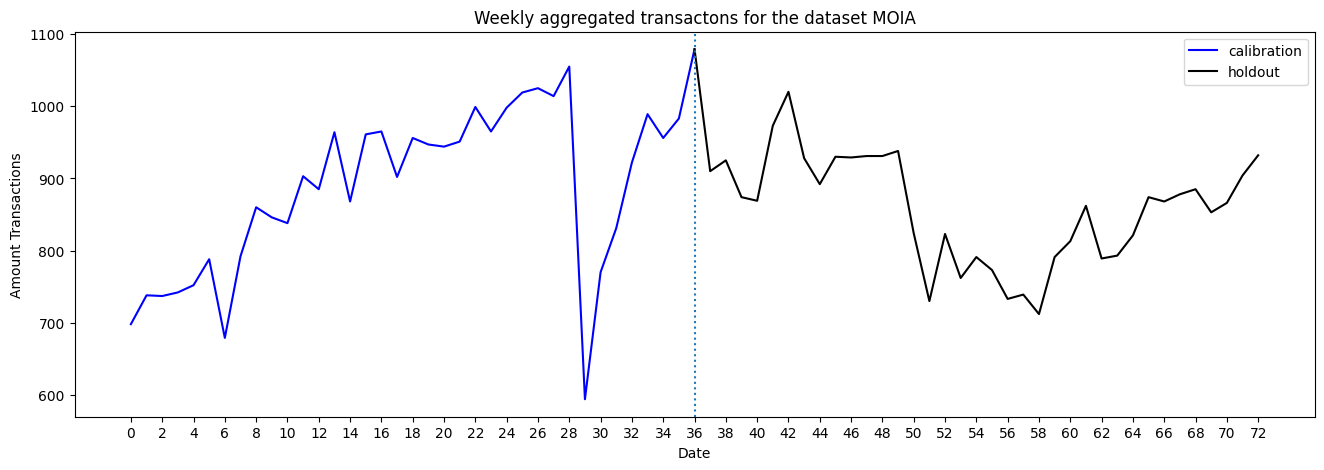

In [133]:
moia_times_series = moia_df.groupby(["year","week"], as_index=False).agg(Trans_count=("date", "count")).sort_values(by=["year","week"]).reset_index(drop=True)
moia_times_series["year"] = moia_times_series["year"].apply(lambda x: pd.to_datetime(datetime.date(int(x), 1, 1)))
moia_times_series["relative"] = moia_times_series["week"].apply(lambda x: relativedelta(weeks=+int(x)))
moia_times_series["date"] = moia_times_series["year"] + moia_times_series["relative"]
plt.figure(figsize=(16,5))
plt.plot(moia_times_series[moia_times_series.date <= "2022-02-19"]["date"].index, 
        moia_times_series[moia_times_series.date <= "2022-02-19"]["Trans_count"], color='blue', label='calibration')
plt.plot(moia_times_series[moia_times_series.date >= "2022-02-19"]["date"].index, 
        moia_times_series[moia_times_series.date >= "2022-02-19"]["Trans_count"], color='black', label='holdout')
plt.axvline(len(moia_times_series[moia_times_series.date <= training_end_moia])-1, linestyle=':')
plt.xticks(moia_times_series.index[::2])

plt.title('Weekly aggregated transactons for the dataset MOIA')
plt.xlabel("Date")
plt.ylabel("Amount Transactions")
#plt.xticks(rotation=45, ha='right')
#plt.savefig("plots/moia_timeseries.png", dpi=600)
plt.legend()
plt.show()

In [134]:
moia_df = moia_df[["date","customer_id"]]

In [135]:
data_prep_moia = preprocessing.Preprocessing(df=moia_df,
training_start=training_start_moia,
training_end=training_end_moia,
holdout_start=holdout_start_moia,
holdout_end=holdout_end_moia,
batch_train_size=32,
name="moia")

In [136]:
train_loader_moia, val_dataloader_moia = data_prep_moia.run(dl_framwork="pytorch")

TRUE


preparing dataset:   0%|          | 0/5756 [00:00<?, ?it/s]

Shape of x_train: torch.Size([5180, 36, 2]) Shape of x_val: torch.Size([576, 36, 2])


In [159]:
model_moia = abstract_lstm.Abstract_Lstm(max_weeks=52, max_trans=8)

In [160]:
model_moia.train(num_epochs=10,learning_rate=0.01,training_loader=train_loader_moia,validation_loader=val_dataloader_moia)

504309333273258.7
414393715712910.25
359662470241393.75
328387472829098.7
320568723476024.9
Best Epoch: 5, mape: 320568723476024.87500


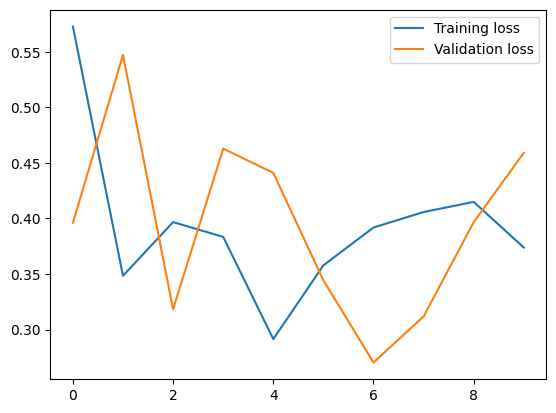

In [161]:
model_moia.plot_losses()

In [162]:
moia_post_processing = postprocessing.Postprocessing(
    df= moia_df,
    model= model_moia,
    holdout_calender = data_prep_moia.holdout_calendar,
    calender = data_prep_moia.calender,
    calibration= data_prep_moia.calibration,
    batch_size_pred = data_prep_moia.no_valid_samples,
    holdout = data_prep_moia.holdout,
    training_end = training_end_moia,
    holdout_start = holdout_end_moia,
    name="moia"
)


In [163]:
moia_post_processing.run(dl_framework="pytorch")

The seed shape is individuals (5756) X calibration length (37) X number of features (2)
no_samples=5756
no_timesteps=37
no_features=2
no_batches=10
4


simulating scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

predictions.shape=(2, 5756, 72, 1)


In [164]:
y_pred = moia_post_processing.convertet_predictions
y_pred = np.squeeze(np.mean(y_pred, axis=0))
y_pred = y_pred[:,36:]
y_pred.shape

(5756, 36)

In [165]:
moia_post_processing.get_root_mean_squared()

0.5902672459056715

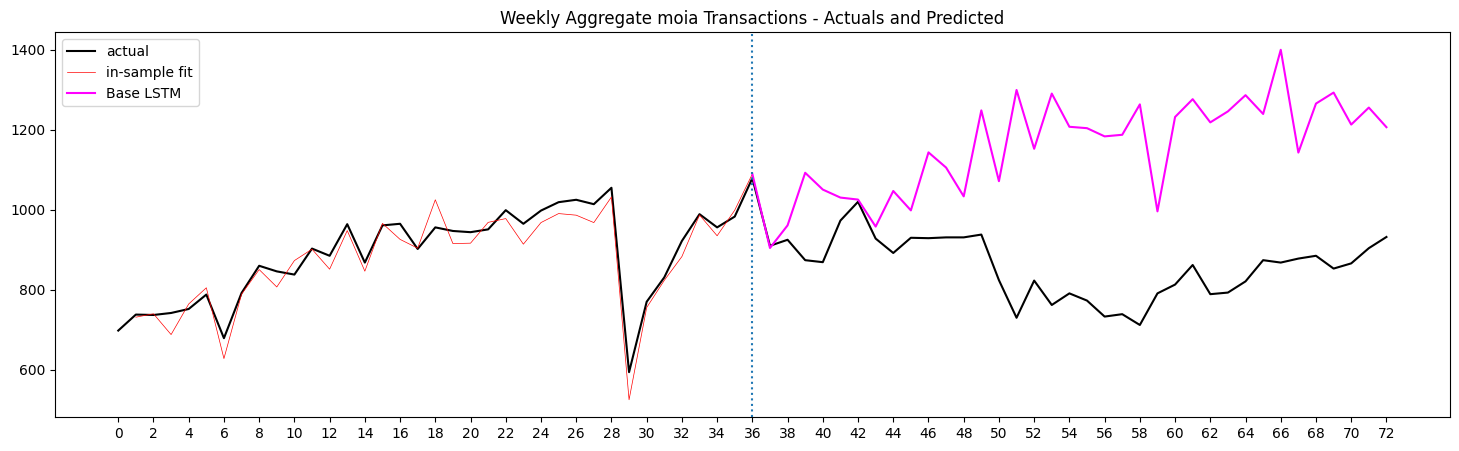

In [166]:
moia_post_processing.show_predictions(type="full", dl_framework="pytorch")

## grocery

In [167]:
result = pyreadr.read_r('data/groceryElog.rda')
df_grocery = pd.DataFrame(result["groceryElog"])
df_grocery["date"] = pd.to_datetime(df_grocery["date"])
df_grocery = df_grocery.rename(columns={'cust': 'customer_id'})
df_grocery["customer_id"] = df_grocery["customer_id"].astype("object")
df_grocery["date"] = pd.to_datetime(df_grocery["date"],format='%Y%m%d')
df_grocery.head()

,customer_id,date
0,1,2006-01-01
1,2,2006-01-01
2,2,2006-12-19
3,3,2006-01-01
4,3,2006-01-10


In [168]:
aggregate_counts_grocery = df_grocery.copy(deep=True)
aggregate_counts_grocery['year'] = aggregate_counts_grocery['date'].dt.year
aggregate_counts_grocery['week'] = (aggregate_counts_grocery['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
aggregate_counts_grocery = aggregate_counts_grocery.groupby(['year', 'week']).agg({'customer_id': 'count', 'date': 'min'}).reset_index()

In [169]:
aggregate_counts_grocery[aggregate_counts_grocery.index == 51]

,year,week,customer_id,date
51,2006,51,58,2006-12-23


In [170]:
training_start_grocery = "2006-01-01"
training_end_grocery = "2006-12-23"
holdout_start_grocery = "2006-12-23"
holdout_end_grocery = "2007-12-30"
date_format    = '%Y-%m-%d'

In [47]:
len(aggregate_counts_grocery[aggregate_counts_grocery.date <= training_end_grocery])-1

51

In [48]:
aggregate_counts_grocery[aggregate_counts_grocery.date >= training_end_grocery]["customer_id"]

51     58
52     55
53     93
54     90
55     85
56     82
57     93
58     72
59     67
60     79
61     89
62     74
63     71
64     74
65     72
66     59
67     84
68     71
69     63
70     69
71     49
72     73
73     71
74     79
75     49
76     64
77     62
78     56
79     63
80     50
81     51
82     51
83     46
84     55
85     62
86     58
87     61
88     56
89     76
90     62
91     65
92     66
93     62
94     64
95     53
96     61
97     62
98     59
99     58
100    53
101    64
102    59
103    27
Name: customer_id, dtype: int64

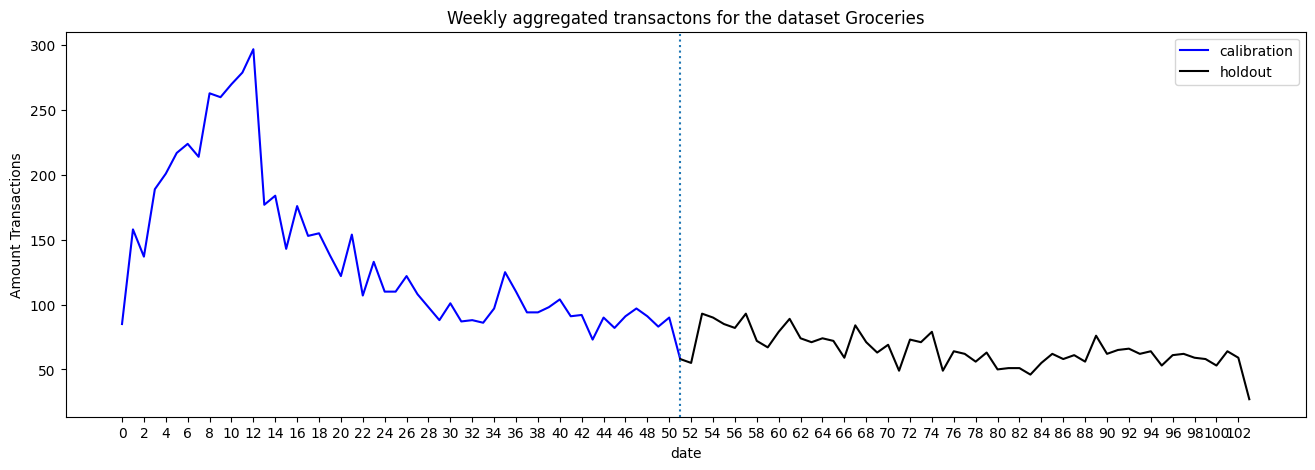

In [171]:
plt.figure(figsize=(16,5))
plt.plot(aggregate_counts_grocery[aggregate_counts_grocery.date <= training_end_grocery]["date"].index, 
        aggregate_counts_grocery[aggregate_counts_grocery.date <= training_end_grocery]["customer_id"], color='blue', label='calibration')
plt.plot(aggregate_counts_grocery[aggregate_counts_grocery.date >= training_end_grocery]["date"].index, 
        aggregate_counts_grocery[aggregate_counts_grocery.date >= training_end_grocery]["customer_id"], color='black', label='holdout')
plt.axvline(len(aggregate_counts_grocery[aggregate_counts_grocery.date <= training_end_grocery])-1, linestyle=':')
plt.xticks(aggregate_counts_grocery.index[::2])
#plt.xticks(aggregate_counts_grocery.index[::2])
plt.title('Weekly aggregated transactons for the dataset Groceries')
plt.xlabel("date")
plt.ylabel("Amount Transactions")
plt.legend()
plt.show()

In [172]:
data_prep_grocery = preprocessing.Preprocessing(df=df_grocery,
training_start=training_start_grocery,
training_end=training_end_grocery,
holdout_start=holdout_start_grocery,
holdout_end=holdout_end_grocery,
batch_train_size=32,
name="grocery")

In [173]:
train_grocery, val_grocery = data_prep_grocery.run(dl_framwork="pytorch")

TRUE


preparing dataset:   0%|          | 0/1525 [00:00<?, ?it/s]

Shape of x_train: torch.Size([1373, 50, 2]) Shape of x_val: torch.Size([152, 50, 2])


In [174]:
with open("feature_config.json", "r") as f:
    data = json.load(f)
max_weeks = data["grocery"]["features"]["weeks"]
max_trans = data["grocery"]["features"]["trans"]
model_grocery = abstract_lstm.Abstract_Lstm(max_weeks=max_weeks, max_trans=max_trans)
model_grocery.train(num_epochs=10,learning_rate=0.001,training_loader=train_grocery,validation_loader=val_grocery)

833165931063541.8
785315185022730.2
565764703188418.5
447545212969943.06
436286213901516.8
427841964600197.1
374361719025172.5
284289726477762.56
270215977642229.75
216735732067205.16
Best Epoch: 8, mape: 216735732067205.15625


In [98]:
post_processing_grocery =postprocessing.Postprocessing(df= df_grocery,
        model= model_grocery,
        holdout_calender = data_prep_grocery.holdout_calendar,
        calender = data_prep_grocery.calender,
        calibration= data_prep_grocery.calibration,
        batch_size_pred = data_prep_grocery.no_valid_samples,
        holdout = data_prep_grocery.holdout,
        training_end = training_end_grocery,
        holdout_start = holdout_start_grocery,
        name="Grocery")
post_processing_grocery.run(dl_framework="pytorch")

The seed shape is individuals (1525) X calibration length (51) X number of features (2)
no_samples=1525
no_timesteps=51
no_features=2
no_batches=11
147


simulating scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

predictions.shape=(2, 1525, 103, 1)


In [176]:
post_processing_grocery.get_root_mean_squared()

0.22587767438584389

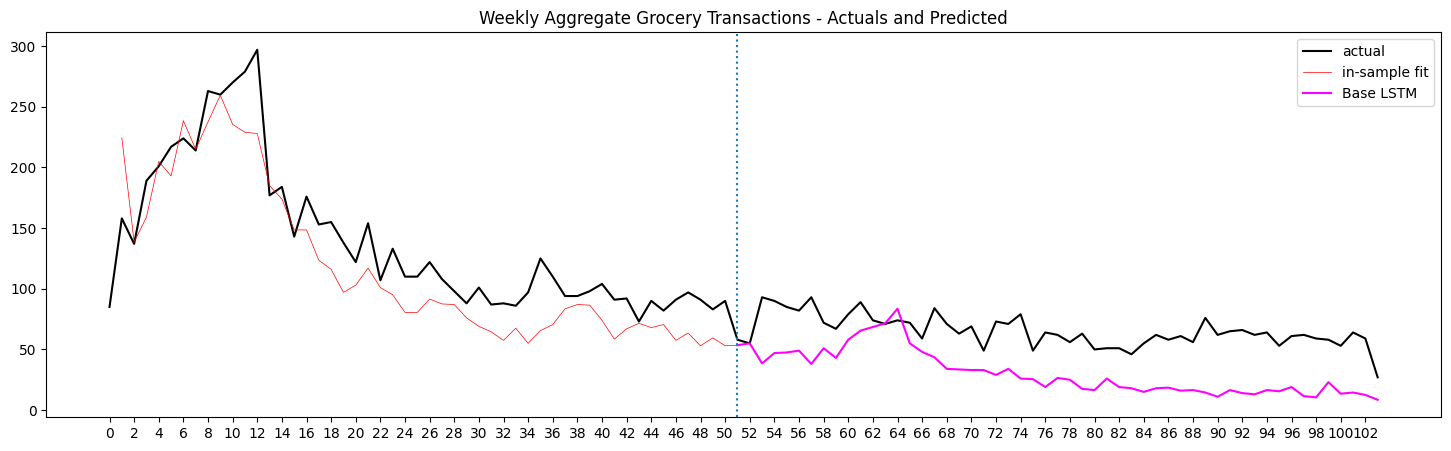

In [177]:
post_processing_grocery.show_predictions(type="full", dl_framework="pytorch")

In [101]:
post_processing_grocery.get_prediction_bias()

3447


-52.72700899332753

In [102]:
post_processing_grocery.get_mean_absolute_percentage_error()

0.5437341623030127

## Retail


In [ ]:
# Import Dataset
df_retailer = pd.read_csv("data/uk_retail_cleaned.csv")
df_retailer["date"] = pd.to_datetime(df_retailer["date"])
df_retailer.head()

In [ ]:
aggregate_counts_retail = df_retailer.copy(deep=True)
aggregate_counts_retail['year'] = aggregate_counts_retail['date'].dt.year
aggregate_counts_retail['week'] = (aggregate_counts_retail['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
aggregate_counts_retail = aggregate_counts_retail.groupby(['year', 'week']).agg({'customer_id': 'count', 'date': 'min'}).reset_index()

In [ ]:
aggregate_counts_retail

In [ ]:
training_start_retail = "2009-12-02"
training_end_retail = "2010-12-02"
holdout_start_retail = "2010-12-02"
holdout_end_retail = "2011-12-02"
date_format    = '%Y-%m-%d'

In [ ]:
aggregate_counts_retail[aggregate_counts_retail.index == 53]


In [ ]:
aggregate_counts_retail[aggregate_counts_retail.date <= training_end_retail]["date"].index

In [ ]:

plt.figure(figsize=(16,5))
plt.plot(aggregate_counts_retail[aggregate_counts_retail.date <= training_end_retail]["date"].index, 
        aggregate_counts_retail[aggregate_counts_retail.date <= training_end_retail]["customer_id"], color='blue', label='calibration')
plt.plot(aggregate_counts_retail[aggregate_counts_retail.date >= training_end_retail]["date"].index, 
        aggregate_counts_retail[aggregate_counts_retail.date >= training_end_retail]["customer_id"], color='black', label='holdout')
plt.axvline(len(aggregate_counts_retail[aggregate_counts_retail.date <= training_end_retail])-1, linestyle=':')
plt.xticks(aggregate_counts_retail.index[::2])

plt.title('Weekly aggregated transactons for the dataset Retail')
plt.xlabel("date")
plt.ylabel("Amount Transactions")
plt.legend()
plt.show()

In [ ]:
data_prep_retail = preprocessing.Preprocessing(df=df_retailer,
training_start=training_start_retail,
training_end=training_end_retail,
holdout_start=holdout_start_retail,
holdout_end=holdout_end_retail,
batch_train_size=32,
name="retail")

In [ ]:
train_retail, val_retail = data_prep_retail.run(dl_framwork="pytorch")

In [ ]:
with open("feature_config.json", "r") as f:
    data = json.load(f)
max_weeks = data["retail"]["features"]["weeks"]
max_trans = data["retail"]["features"]["trans"]
model_retail = abstract_lstm.Abstract_Lstm(max_weeks=52, max_trans=725)
model_retail.train(num_epochs=10,learning_rate=0.001,training_loader=train_retail,validation_loader=val_retail)

In [ ]:
data_prep_retail.holdout_calendar.shape

In [ ]:
post_processing_retail =postprocessing.Postprocessing(df= df_retailer,
        model= model_retail,
        holdout_calender = data_prep_retail.holdout_calendar,
        calender = data_prep_retail.calender,
        calibration= data_prep_retail.calibration,
        batch_size_pred = data_prep_retail.no_valid_samples,
        holdout = data_prep_retail.holdout,
        training_end = training_end_retail,
        holdout_start = holdout_start_retail,
        name="Retail")
post_processing_retail.run(dl_framework="pytorch")

In [ ]:
post_processing_retail.aggregate_prediction

In [ ]:
post_processing_retail.show_predictions(type="full", dl_framework="pytorch")